# Minería de flujos de datos

## Imports

In [69]:
import time
import river
import numpy as np
import pandas as pd
import seaborn as sns
from river import stream
from river import naive_bayes as nb
from river.tree import HoeffdingTreeClassifier
from river.tree import SGTClassifier
from river.metrics import Accuracy
from scipy.stats import normaltest, mannwhitneyu
from scipy.stats.mstats import kruskalwallis
from matplotlib import pyplot as plt

## Análisis del flujo de datos

In [59]:
data_stream = pd.read_csv('CartPoleInstances.csv')

Visualizamos el flujo de datos para cada una de las variables.

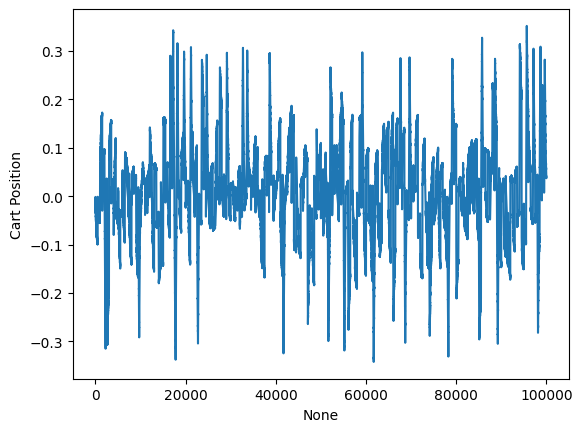

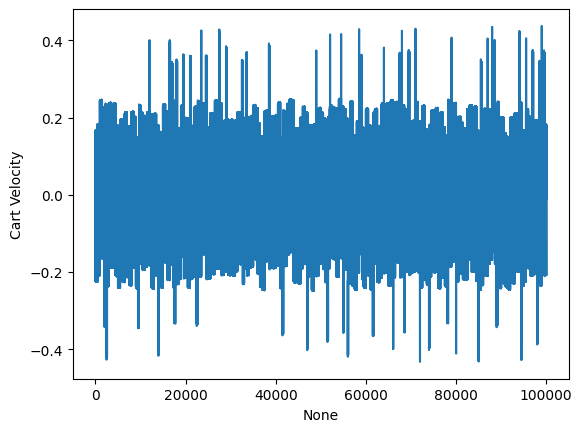

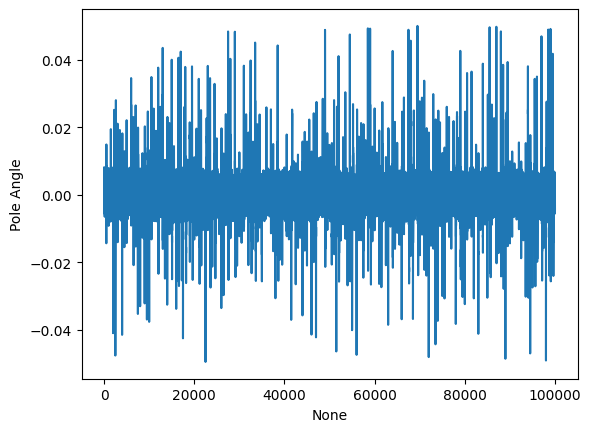

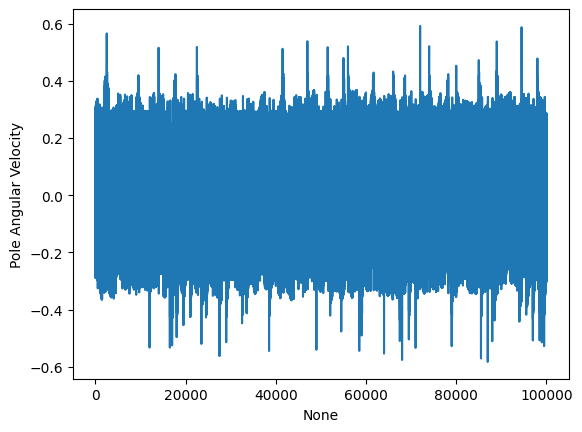

In [63]:
for column in data_stream.columns[:-1]:
    sns.lineplot(data_stream, x=data_stream.index, y=column)
    plt.show()

In [96]:
data_stream.describe()

,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,action
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.010942,0.000387,-0.000024,-0.000435,0.500000
std,0.113050,0.138039,0.005266,0.200526,0.500003
min,-0.342260,-0.432959,-0.049582,-0.582749,0.000000
25%,-0.055560,-0.140464,-0.003144,-0.137653,0.000000
50%,0.016458,0.001084,-0.000051,-0.001088,0.500000
75%,0.080526,0.058726,0.003097,0.157193,1.000000
max,0.351488,0.437697,0.050076,0.591894,1.000000


Visualmente no se aprecia Concept Drift como era de esperar, puesto que 
las leyes de la física no cambián.

Ademas, las variables se encuentran normalizadas en un intervalo [-1, 1], con
una media cercana a 0, por lo que no consideramos que sea necesario un escalado
ni normalización de estas.

## Train

### Definición de variables y funciones

In [110]:
datafile = 'CartPoleInstances.csv'

def AttributeNames():
    return ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']

def ClassName():
    return 'action'

# Conversores de datos para el flujo con  iter_csv
converters= {}
for i in AttributeNames():
    converters[i]= float
converters[ClassName()]= lambda x:int(float(x))

# Experimento a realizar durante el entrenamiento de los modelos.
def experiment(model, dataflow, metric, steps, history_steps=100):
    """ Experimento a realizar durante el entrenamiento de los modelos.

    Args:
        model: Modelo a usar para el entrenamiento
        dataflow: Flujo de datos
        metric: Metrica a usar para la evaluación
        steps: Numero de pasos sobre los que se va a realizar el entrenamiento
        history_steps: Numero de iteraciones tras las que se va a almacenar el resultado de la metrica. Defaults to 100.

    Returns:
        list[int], float: Historial de evaluaciones usando la métrica *metric*, tiempo de entrenamiento 
    """
    history = []
    start = time.time()
    #data = dataflow.take(steps)
    for step, sample in enumerate(dataflow):
        x, y = sample
        model.learn_one(x, y)
        pred = model.predict_one(x)
        metric.update(y, pred)
        
        if (step+1)%history_steps == 0 or step == steps-1:
            history.append(metric.get())
    end = time.time()
    elapsed = end - start
    return history, elapsed


### Entrenamiento de los modelos

Modelo Naive Bayes Gaussiano, usado como *baseline*.

In [73]:
dataflow = stream.iter_csv(datafile, converters=converters, target=ClassName())
nb_model = nb.GaussianNB()
nb_metric = Accuracy()
nb_history, nb_time = experiment(
    model=nb_model, 
    dataflow=dataflow, 
    steps=100000,
    metric=nb_metric
)
print("Accuracy promedio de NB: {} +- {}".format(np.mean(nb_history), np.std(nb_history)))
print("Accuracy final: {}".format(nb_history[-1]))

Accuracy promedio de NB: 0.801154396514772 +- 0.004612552979091033
Accuracy final: 0.80484


Modelo Hoeffding Tree (VFDT).

In [72]:
dataflow = stream.iter_csv(datafile, converters=converters, target=ClassName())
ht_model = HoeffdingTreeClassifier()
ht_metric = Accuracy()
ht_history, ht_time = experiment(
    model=ht_model, 
    dataflow=dataflow, 
    steps=100000,
    metric=ht_metric
)
print("Accuracy promedio de HT: {} +- {}".format(np.mean(ht_history), np.std(ht_history)))
print("Accuracy final: {}".format(ht_history[-1]))

Accuracy promedio de HT: 0.9103814820661298 +- 0.036479113107289234
Accuracy final: 0.94066


In [71]:
dataflow = stream.iter_csv(datafile, converters=converters, target=ClassName())
sg_model = SGTClassifier(grace_period=200, max_depth=20)
sg_metric = Accuracy()
sg_history, ht_time = experiment(
    model=sg_model, 
    dataflow=dataflow, 
    steps=100000,
    metric=sg_metric
)
print("Accuracy promedio de SGT: {} +- {}".format(np.mean(sg_history), np.std(sg_history)))
print("Accuracy final: {}".format(sg_history[-1]))

Accuracy promedio de SGT: 0.8914433767192236 +- 0.038581909948757064
Accuracy final: 0.9154


### Comparación de resultados de entrenamiento:

In [65]:
# Test de normalidad de las distribuciones
_, nb_pval = normaltest(nb_history)
_, ht_pval = normaltest(ht_history)
_, sg_pval = normaltest(sg_history)
print("p-value de normalidad: \n\t- NB: {}\n\t- HT: {}\n\t- SGT: {}".format(nb_pval, ht_pval, sg_pval))

p-value de normalidad: 
	- NB: 7.842432677650351e-92
	- HT: 5.405265585793889e-65
	- SGT: 1.098423981347103e-202


Se rechaza la hipótesis nula de que las distribuciones sean normales, por
lo que usaremos el test no paramétrico Kruskal-Wallis para compararlas.

In [68]:
_, pval = kruskalwallis(nb_history, ht_history, sg_history)
print("Kruskal-Wallis p-value: {}".format(pval))

Kruskal-Wallis p-value: 0.0


Se rechaza la hipótesis nula de que las distribuciones sean equvalentes (p-value < 0.05).
Compararemos las distribuciones dos a dos, empleando el test de Mann-Whitney

In [70]:
_, nbht_pval = mannwhitneyu(nb_history, ht_history)
_, nbsg_pval = mannwhitneyu(nb_history, sg_history)
_, htsg_pval = mannwhitneyu(ht_history, sg_history)
print("p-value Mann-Whitney U Test: \n\t- NB vs HT: {}\n\t- NB vs SGT: {}\n\t- HT vs SGT: {}".format(nbht_pval, nbsg_pval, htsg_pval))

p-value Mann-Whitney U Test: 
	- NB vs HT: 0.0
	- NB vs SGT: 3.643029872356413e-294
	- HT vs SGT: 8.258626077397134e-91


Se rechaza la hipótesis nula de que cualquier par de distribuciones sean iguales.

Por lo tanto, en el proceso de entrenamiento diremos que ha dado un mejor resultado
Hoeffdin Tree ya que es el que mayor *accuracy* media y final ha obtenido.

## Test

### Definición de funciones

In [97]:
import gymnasium as gym

envName = 'CartPole-v1'

def action_selection(obs, model):
    action = model.predict_one(obs)
    return action

# Definición del experimento de test
def test_experiment(model, n_times=200):
    """Ejecuta el experimento de CartPole N veces usando un modelo
    preentrenado para la toma de decisiones.

    Args:
        model: Modelo preentrenado a usar para la toma de decisiones 
        n_times: Número de veces que se ejecutará el experimento

    Returns:
        list[float], list[int]: Lista de tiempos de toma de decisiones y lista
        de recompesas conseguidas en cada experimento.
    """

    # Creación del entorno
    env= gym.make(envName, render_mode=None)
    
    # Jugar un episodio
    decision_times = []
    performances = []
    reps = 0
    while reps < n_times:
        obs, _= env.reset() # Inicialización del entorno
        #env.render() # Renderizar entorno para visualización
        truncated, done= False, False
        R= 0 # Recompensa total obtenida
        while not (truncated or done):
            x = {
                "Cart Position": obs[0],
                "Cart Velocity": obs[1],
                "Pole Angle": obs[2],
                "Pole Angular Velocity": obs[3]
            }
            # Selección de acción
            start = time.time()
            action= action_selection(x, model)
            end = time.time()
            decision_times.append(end-start)
            
            # Ejecución de la acción y obtención de recompensa y siguiente estado
            obs, r, done, truncated, _= env.step(action)
            #env.render() # Renderizar entorno para visualización
            R+= r # Actualización de recompensa total (performance)
        performances.append(R)
        reps += 1
    
    print('Tiempo medio de toma de decisiones: {}'.format(np.mean(decision_times)))
    print('Recompensa media en 200 ejecuciones: {}'.format(np.mean(performances)))
    return decision_times, performances

In [98]:
nb_times, nb_performance = test_experiment(model=nb_model)

Tiempo medio de toma de decisiones: 6.251157871406145e-05
Recompensa media en 200 ejecuciones: 63.615


In [99]:
sg_times, sg_performance = test_experiment(model=sg_model)

Tiempo medio de toma de decisiones: 2.914832629142928e-05
Recompensa media en 200 ejecuciones: 457.03


In [100]:
ht_times, ht_performance = test_experiment(model=ht_model)

Tiempo medio de toma de decisiones: 2.1726115956210425e-05
Recompensa media en 200 ejecuciones: 364.95


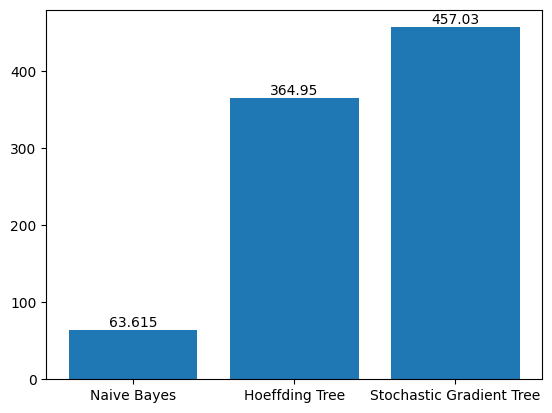

In [108]:
models = ['Naive Bayes', 'Hoeffding Tree', 'Stochastic Gradient Tree']
results = [np.mean(nb_performance), np.mean(ht_performance), np.mean(sg_performance)]
plt.bar(models, results, label=results)
for index, value in enumerate(results):
    plt.text(index, value + 5, value, ha='center')
plt.show()

### Comparación de resultados de test

In [81]:
_, nb_pval = normaltest(nb_performance)
_, sg_pval = normaltest(sg_performance)
_, ht_pval = normaltest(ht_performance)
print("p-value de normalidad: \n\t- NB: {}\n\t- HT: {}\n\t- SGT: {}".format(nb_pval, ht_pval, sg_pval))

p-value de normalidad: 
	- NB: 9.68637060199934e-13
	- HT: 1.2763966717311274e-141
	- SGT: 1.8826890922750132e-14


Rechazamos la normalidad de las distribuciones, por lo las compararemos dos a
dos:

In [86]:
_, nbht_pval = mannwhitneyu(nb_performance, ht_performance)
_, nbsg_pval = mannwhitneyu(nb_performance, sg_performance)
_, htsg_pval = mannwhitneyu(ht_performance, sg_performance)
print("p-value Mann-Whitney U Test: \n\t- NB vs HT: {}\n\t- NB vs SGT: {}\n\t- HT vs SGT: {}".format(nbht_pval, nbsg_pval, htsg_pval))

p-value Mann-Whitney U Test: 
	- NB vs HT: 4.7265731067806235e-28
	- NB vs SGT: 2.486288546599731e-71
	- HT vs SGT: 4.734318229776458e-05


Rechazamos la hipótesis nula de que cualquier par de distribuciones sean equivalentes.
Por lo tanto, podemos decir que el modelo que mejor resultado obtiene en test es
el *Stochastic Gradient Tree Classifier* ya que de media obtiene una puntuación
por encima del resto.